**Synthetic Regression Task:  y= sin(x1) + cos(x2)**



1.   Generate 1000 Random 2D points
2.   Compute y=sin(x1) + cos(x2)
3.   Train RelationalFieldNetwork to learn this mapping








Epoch 0: Loss = 0.5730
Epoch 50: Loss = 0.1230
Epoch 100: Loss = 0.0211
Epoch 150: Loss = 0.0207
Epoch 200: Loss = 0.0207
Epoch 250: Loss = 0.0207
Epoch 300: Loss = 0.0207
Epoch 350: Loss = 0.0207
Epoch 400: Loss = 0.0207
Epoch 450: Loss = 0.0207


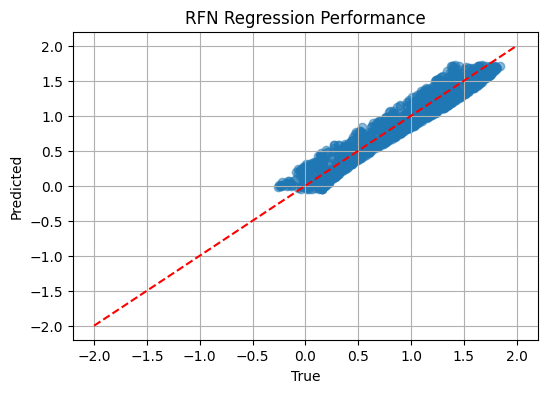

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Use the RFN we just created
class RelationalFieldLayer(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.q = nn.Linear(dim, dim)
        self.k = nn.Linear(dim, dim)
        self.score_fn = nn.Sequential(
            nn.Linear(dim * 2, dim),
            nn.ReLU(),
            nn.Linear(dim, 1)
        )

    def forward(self, x):
        B, N, D = x.shape
        q_proj = self.q(x)
        k_proj = self.k(x)

        q_expand = q_proj.unsqueeze(2).expand(-1, -1, N, -1)
        k_expand = k_proj.unsqueeze(1).expand(-1, N, -1, -1)

        pair_input = torch.cat([q_expand, k_expand], dim=-1)
        scores = self.score_fn(pair_input).squeeze(-1)

        weights = torch.softmax(scores, dim=-1)
        updated = torch.bmm(weights, x)
        return updated

class RelationalFieldNetwork(nn.Module):
    def __init__(self, dim=2, depth=3, out_dim=1):
        super().__init__()
        self.embed = nn.Linear(dim, dim)
        self.layers = nn.ModuleList([RelationalFieldLayer(dim) for _ in range(depth)])
        self.output = nn.Linear(dim, out_dim)

    def forward(self, x):
        x = self.embed(x)
        x = x.unsqueeze(1)  # (B, 1, D)
        for layer in self.layers:
            x = layer(x)
        return self.output(x.squeeze(1))


# Create data
torch.manual_seed(0)
N = 1000
X = 2 * torch.rand(N, 2) - 1  # range [-1, 1]
y = torch.sin(X[:, 0]) + torch.cos(X[:, 1])
y = y.unsqueeze(1)

# Model, loss, optimizer
model = RelationalFieldNetwork(dim=2, depth=3)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
for epoch in range(500):
    model.train()
    pred = model(X)
    loss = loss_fn(pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}")


import matplotlib.pyplot as plt

with torch.no_grad():
    preds = model(X).squeeze().numpy()
    true = y.squeeze().numpy()

plt.figure(figsize=(6, 4))
plt.scatter(true, preds, alpha=0.5)
plt.plot([-2, 2], [-2, 2], 'r--')
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title("RFN Regression Performance")
plt.grid(True)
plt.show()


**Breast cancer prediction from Breast Cancer Wisconsin (Diagnostic) Dataset**

In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch

# Load data
data = load_breast_cancer()
X, y = data.data, data.target

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


class RelationalFieldNetwork(nn.Module):
    def __init__(self, dim=30, depth=3):
        super().__init__()
        self.embed = nn.Linear(dim, dim)
        self.layers = nn.ModuleList([RelationalFieldLayer(dim) for _ in range(depth)])
        self.output = nn.Sequential(
            nn.Linear(dim, 1),
            nn.Sigmoid()  # for binary classification
        )

    def forward(self, x):
        x = self.embed(x)
        x = x.unsqueeze(1)  # (B, 1, D)
        for layer in self.layers:
            x = layer(x)
        return self.output(x.squeeze(1))


model = RelationalFieldNetwork(dim=30, depth=3)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(100):
    model.train()
    pred = model(X_train)
    loss = loss_fn(pred, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        acc = ((pred > 0.5) == y_train).float().mean()
        print(f"Epoch {epoch}: Loss={loss.item():.4f}, Accuracy={acc:.4f}")


model.eval()
with torch.no_grad():
    pred_test = model(X_test)
    acc_test = ((pred_test > 0.5) == y_test).float().mean()
    print(f"Test Accuracy: {acc_test:.4f}")


Epoch 0: Loss=0.7166, Accuracy=0.3934
Epoch 10: Loss=0.1173, Accuracy=0.9626
Epoch 20: Loss=0.0725, Accuracy=0.9736
Epoch 30: Loss=0.0663, Accuracy=0.9802
Epoch 40: Loss=0.0615, Accuracy=0.9824
Epoch 50: Loss=0.0581, Accuracy=0.9846
Epoch 60: Loss=0.0554, Accuracy=0.9846
Epoch 70: Loss=0.0529, Accuracy=0.9846
Epoch 80: Loss=0.0509, Accuracy=0.9846
Epoch 90: Loss=0.0494, Accuracy=0.9890
Test Accuracy: 0.9825
